# An Analysis of How the Writing of Prolific FanFic Authors Changes

<img src="fanfic_charts.png">

One of the largest collections of fiction in the world is fanfiction.net. They do not release official statistics, but a quick analysis indicates that there are at least 6 million unique stories on the site. For comparison, the Library of Congress has 16 million books. What's more, fanfiction.net shows the work-in-progress of the authors that use it. People continue to publish new stories for months and years on end. With the record of their first stories to their most recent, it is a representation of their development as authors.

As a writer myself, I was interested in studying how these authors change over time. I wanted to see if their writing gets more complex, if they use more diverse words. There are other analyses of the content on fanfiction.net focusing on many other aspects of fanfiction. Two that I read while working on this are <a href="https://ir.lib.uwo.ca/cgi/viewcontent.cgi?article=1068&context=fimspub">Comparative Stylistic Fanfiction Analysis: Popular
and Unpopular Fics across Eleven Fandoms</a> by Victoria L. Rubin and Vanessa Girouard and <a href="https://www.aclweb.org/anthology/D/D16/D16-1218.pdf">Beyond Canonical Texts: A Computational Analysis of Fanfiction</a> by Smitha Milli and David Bamman. The first focused on the relationship between style and popularity of fanfiction, while the second focused on how fanfiction differs from canon and how the authors relate to their readers. I am focusing, instead, on the authors themselves, and how they change (or do not change) as they continue to write.

The following will guide you through my process, starting with data collection and organization, moving into analysis and drawing conclusions.

## *Skipping Ahead*

A whole lot of this solely involves collecting data (over the span of a week or more) from fanfiction.net. If you want to follow along, maybe try some of your own analysis, you can <a href="">download a partial database</a> of the metadata I collected, and then <a href="#skip1">skip ahead</a> to after where I've done the analysis of the raw texts. Or, if you just want to see the charts and graphs, you can <a href="#skip2">skip</a> straight to that part.

Now, back to:

# Data Collection

If you're time-limited (as I was) this can be a very problematic part of the process. I wanted to have a large data set, which meant downloading lots of stories. In particular, as I was focusing on the authors, I wanted to get every story by an author, and I only wanted authors who had been writing long enough that I could expect to see some change during that time. For a lot of authors, that can be over a hundred distinct stories, and I didn't know which ones I was going to be getting when I dove in. As such, I just started downloading quickly, knowing it would take a while for the data to come in.

What do I mean by a while? My computer was continuously downloading stories for about five days. I'll get into the reasons it takes so long below.

## Getting Started

#### Step 1: Basic requirements

As always, with Python you must import some tools. The data collection is mostly just regular expressions and BeautifulSoup. I also added some file aliases for where to store my downloads.

In [39]:
import time, re, requests, io, os, random
from urllib.parse import unquote_plus
from bs4 import BeautifulSoup

ids = 'ids_list.txt' 
raws = 'raw_stories' # This won't create the directory, I did made all my directories outside of python

#### Step 2: Try some options out

There are quite a few third-party scrapers and APIs for fanfiction.net out there. I loaded some up, tried them out, and got some combination of errors and data-gaps from all of them. They were all very focused on getting stories, and I was focused on authors. As everything missed my needs slightly, I went with the one that looked easiest to modify: https://github.com/smilli/fanfiction (They wrote the second paper I linked above). As they don't have a license on their page, the code of the scraper (aside from the part I added) isn't listed below. You'll have to download it and modify it yourself to make this work.

#### Step 3: Modify the scraper

The scraper I used had a few shortcomings:

* It failed if an element was missing (eg pre_story_links was often blank) and needed try/except statements around that
* It assumed both publication and update times would be present, but only one date was given if a story had been posted and never updated, so I set both dates to the same if one was missing.
* The reviews collection only ever got the first page of reviews, which limited it to 15. I added an iteration-counter and made the function recursive, then checked whether the "Next »" tag was present on the page.
* It didn't scrape author pages, only story pages

How to figure out what modification are needed? Turns out it's surprisingly straightforward: Look at the actual website where a story gives incorrect results, copy a distinct bit of text next to what isn't captured, and search the results of a beautifulsoup scrape of the page for that. For example, I noticed it wasn't showing all the reviews on some stories, so I found a page with the problem (https://www.fanfiction.net/r/13051824/). If you look at the bottom of that page, you'll see a "Next »" button, indicating there are multiple pages. The scraper was only taking page #1. So, I ran BeautifulSoup over it and ensured that the relevant tag would be present:

In [ ]:
# Code appended to the review-scraper to get multiple pages

if (soup.find(text="Next »")):
    return reviews.append(chapter_reviews = self.scrape_reviews_for_chapter(
        story_id, chapter_id, iteration + 1))
else:
    return reviews

###### Figuring out how to scrape a page

*For most things, as in the example above, it's a simple matter of finding some bit of text on the page, then seeing if beautiful soup contains that. For the reviews, the "Next »" text on the page was unique enough that it was easy to detect.*

And scraping the author page? That's a little more involved, the same basic method applies: Go to the website, find the information needed, and search for some of the surrounding text in the BeautifulSoup results. It's important to realize you can't always search for the exact text. For example, fanfiction.net generates the dates and times algorithmically, only storing a UNIX-style seconds integer, so you need to search for other elements near that.

I'm not going to delve into each and every element here, but you can examine the code below and see where I found the relevant bits of data.

In [27]:
def scrape_author(self, author_id):
    """
    Returns a dictionary with the author's information.

    Attributes:
        -id: the id of the author
        -joined: time the author joined ff.net
        -updated: time the author's page was last updated
        -description: the block of text the author has at the head of their page
        -stories: a list object with all of the author's written stories
        -favs: a list object with all of the author's favorite stories
        -fav_auths: a list object with all of the author's favorite authors
    """
    url = '{0}/u/{1}'.format(self.base_url, author_id)
    result = requests.get(url)
    html = result.content
    soup = BeautifulSoup(html, self.parser)
    try:
        joined = int(re.findall(r'Joined\s*<span data-xutime="(\d+)"', str(soup))[0])
    except:
        joined = 100000
        # Why 100000? It's the smallest round number that doesn't cause errors with datetime in python3, 
        # but results in a date that is obviously impossible, so I can be sure to notice errors later

    try:
        updated = int(re.findall(r'Profile Updated:\s*<span data-xutime="(\d+)"', str(soup))[0])
    except:
        updated = joined

    try:
        description = str(soup.find('div', { 'id' : 'bio'}))
    except:
        description = None

    try:
        stories = list()
        for elem in soup.findAll('div', class_='z-list mystories'):
            stories.append(elem['data-storyid'])
    except:
        stories = None

    try:
        favs = list()
        for elem in soup.findAll('div', class_='z-list favstories'):
            favs.append(elem['data-storyid'])
    except:
        favs = None

    try:
        fav_auths = list()
        for elem in re.finditer(r'<a href="\/u\/(\d+)\/', str(soup.find('div', { "id" : "fa" }).contents[0])):
            fav_auths.append(int(elem.group(1)))
    except:
        fav_auths = None

    author_data = {
        'author_id': author_id,
        'joined': joined,
        'updated': updated,
        'description': description,
        'stories': stories,
        'favs': favs,
        'fav_auths': fav_auths
    }
    return author_data

scraper = Scraper()

Alright, now we have a means to get stories from the site. How do we actually use it?

## Storing the Data

If you're approaching a new dataset, you need to decide where the data is going. If it's just a table of facts, even a large table, you can probably store it in a dataframe and (if the need arises) save that directly to disk as a CSV. I wasn't gathering a table, I was gathering a massive amount of raw data. Well, potentially-massive.

I downloaded a random sampling of stories and got an average size of 30kb each, but the real concern was the time to download. Fanfiction.net has the following in its terms of service: 

<blockquote>You agree not to use or launch any automated system, including without limitation, "robots," "spiders," or "offline readers," that accesses the Website in a manner that sends more request messages to the FanFiction.Net servers in a given period of time than a human can reasonably produce in the same period by using a conventional on-line web browser.</blockquote>

That's a problem, because it means the scraper needs to pause for a second between each page-scrape. A page for each author, plus one per fifteen reviews, plus one per-chapter, all told I was averaging 10 seconds per story. I could download a few hundred quickly, but I wanted a large collection. To that end, I started things running with a minimal possible solution.

#### Step 1: Getting story IDs

I actually did this before making the scraper above. I was still fiddling with the data and just started this process in the background that pulled down story_ids and put them into files.

#### Step 1a: Get the book titles

Needing to make a decision, I just grabbed everything in the 'book' category and ignored the other sections, as follows:

In [24]:
r = requests.get('https://www.fanfiction.net/book/')
soup = BeautifulSoup(r.text)

all_titles = list()
for item in soup.findAll(href=re.compile("\/book\/.+")):
    all_titles.append(re.search('.*book\/(.*)\/".*', str(item)).group(1))

Using BeautifulSoup is relatively straightforward if you know regular expressions (regexes). The regex "\/book\/.+" matches any instance of the word 'book' between two slashes, as it appears in all the URLs for the individual book pages. That finds the tags containing book titles, and the next regex extracts a match-group containing just the book title and appends it to the growing list of books with fanfics about them on fanfiction.net

#### Step 1b: Get the IDs

I still was just working on my general idea, so getting a lot of story ids seemed like a good place to start, but it's also a place to go awry.

I made some mistakes early on that affected my results, this being the biggest one. I went through in sequence, grabbing story-ids and putting them in a list. That meant I started with the newest entries in the largest book-fandom on the site. It's not a cardinal sin, but it did skew my data. In my initial pull, everything was Harry Potter fanfic, rather than being a representative sample. I should have randomized things, but instead, I did this:

In [ ]:
# Create the generic request slot that has openings for said titles to be inserted into
base_url = 'https://www.fanfiction.net/book/'
query_string = '/?&srt=1&lan=1&r=103'

failed = list()

for title in titlesList:
    i = 0
    with open(ids, 'a+') as f:
        r = requests.get(base_url + title + query_string + start_point)
        soup = BeautifulSoup(r.text)
        retries = 1
        while True:
            found = False
            time.sleep(retries) #rate-limiting to comply with robot rules
            titlesList = soup.findAll("a", class_="stitle")

            # write each title into the list file
            for item in titlesList:
                f.write("%s\n" % re.search('.*href="\/s\/(\d*)\/.*', str(item)).group(1))

            # stop iterating through this loop if there's no next page available
            if not (soup.find(text="Next »")):
                scripts = soup.findAll("script")
                found = True
                for scrpt in scripts:
                    if re.search('.*/book/' + re.escape(title) + '.*', str(scrpt), re.MULTILINE | re.DOTALL):
                        break
                #if found = True:
                #    break

            # iterate to the next page, or see if we've gotten a bad page
            if found == False:
                r = requests.get('https://www.fanfiction.net/' + soup.find(text="Next »").parent['href'])
                soup = BeautifulSoup(r.text)
                i += 1
                retries = 1
            elif retries > 2:
                failed.append(title + '/' + str(i))
                break
            else:
                retries = 5 # This is done to adjust the wait-time, as sometimes it stalls but isn't actually broken

If you're hoping for better results, you could do the same, but then call random.shuffle() on the results, making the story_ids a more representative sample.

#### Step 2: Getting the stories on-disk

This is the most time-consuming part of the whole process, because the delays from their TOS make it take a great long time. As such, this is also the part I did in a rush. Rather than organizing everything neatly from the start, I just fed it straight to disk and assumed I could sort it out later. Sorting it out was a giant pain, and I recommend having a working database arranged before you actually do this.

(I explain the code further down, on a more extensive example.)

In [ ]:
with open(ids, encoding='latin-1') as in_file:
    ids = set(in_file.readlines())
    ids = list(map(lambda x: x[0:-1], ids))

for story_id in ids:
    with open("unfinished.txt", 'a+') as unfinished, open("finished.txt", 'a+') as finished:
        with open(os.path.join(raws, story_id + ".txt"), 'w') as out_file:
            try:
                result = scraper.scrape_story(story_id, keep_html=False)
                for key, value in result.items():
                    out_file.write(str(key) + ": " + str(value) + "\n")
                finished.write(str(story_id) + "\n")
            except:
                unfinished.write(str(story_id) + "\n")

I included files of what worked and what so I could restart without repeating myself in case of a crash. It turned out that almost half of every page I hit failed to download, initially, adding to the inefficiency. I was about 10,000 stories (and over 24 hours) in when I realized I had been getting only Harry Potter stories, and if I wanted to analyze the **authors**, not just the stories, I needed to get the stories they had written **outside** of the Harry Potter fandom.

#### Step 2b: Getting stories by author, not story

First I made a list of all the authors I already had stories from. As I'd inserted the stories as dicts, finding author_id was quite easy. I also got all the story ids I'd completed so that, once I was getting every story by one of these authors, I didn't repeat myself.

In [ ]:
author_id = re.compile("^author_id: (\d*)")
authors = set()
stories = set()

for f in os.listdir(raws):
    with open(os.path.join(raws, f), 'r') as in_file:
        curr_file = in_file.readlines(10)
        for line in curr_file:
            if story_id.match(line):
                stories.add(story_id.match(line).group(1))
            if author_id.match(line):
                authors.add(author_id.match(line).group(1))
                break # author_id was always after story_id, so I could safely break here

###### How does this work?

*I generated a list of all the files in a directory (the 'raws' directory I defined at the start of all this), then iterated through that list, opening every file read-only. The os.path.join tool is essential when opening files on windows, as it abstracts the system layer away, so I don't have to worry about front- or back-slash differences.*

*I then read the first 10 lines into a list, iterated through the list, pulling out the match-groups that I had defined in my regular expression at the top of the pade. This could have been done more easily yet by just grabbing the first two lines, which always held the relevant data, but I did this in a rush.*

With that done, I moved on to collecting every story I could get from each author in this list.

In [ ]:
fin = set(map(lambda x: x[0:-1], open('finished.txt', 'r').readlines()))

*Arlight, a lot happens in the above line of code. The open command reads a file and readlines takes it line-by-line so it's a list, but this is every line of the file and still had newlines at the end of each author id.*

*The map command applies a function to each line, that function being "lambda x: x[0:-1]", which takes each line and returns all but the last character (that -1 ends the slice 1 character before the end), removing the newline. The exterior set command then makes this a unique set of authors I've finished with, so I can make sure I don't repeat myself.*

In [ ]:
with open("unfinished.txt", 'a+') as unfinished, open("finished.txt", 'a+') as finished:
    for author_id in authors:
        r = requests.get('https://www.fanfiction.net/u/' + author_id)
        soup = BeautifulSoup(r.text)
        time.sleep(1)
        for elem in soup.findAll('div', class_='z-list mystories'):
            story_id = elem['data-storyid']
            if not story_id in stories:
                with open(os.path.join(raws, story_id + ".txt"), 'w') as out_file:
                    if str(author_id) in fin:
                        continue
                    try:
                        result = scraper.scrape_story(story_id, keep_html=False)
                        for key, value in result.items():
                            out_file.write(str(key) + ": " + str(value) + "\n")
                        stories.add(story_id)
                        finished.write(str(story_id) + "\n")
                    except:
                        unfinished.write(str(story_id) + "\n")

###### Some more complex code

*The website is pulled down and parsed, and I add a time-delay to meet the TOS. Then, I parse that html for the 'z-list mystories' that is the class identifier of the div tags all the stories are in, collect the list of stories, and iterate through that list of stories.*

*Here, I make use of the list I created earlier, calling continue (skipping the rest of that loop iteration) if they're in the finished-stories list. If they're not, I call the scraper to get the story, I write the file to disk, and I extend my finished/unfinished lists.* 

*The finished/unfinished may seem random, but it's very important. This runs for a **long** time. Computers crash, the power goes out, the internet decides to fail, and the entire process gets derailed. Those files let me just restart the process without repeating myself.*

## The Waiting Game

Seriously, this is very slow. My process ran for 5 days to gather 63,034 stories. How to wait? I recommend binging something fun. Legends of Tomorrow was on Netflix when I ran mine, praise Beebo, although you may want to do something more productive.

For example, you could starting thinking about the next step of this whole mishigaas:

# Data Organization

Alright, so you have a few thousand stories and you want to analyze the data. Problem is, that data is just a giant mess on your hard-drive, with the metadata in the same file as the text, making it all super-slow to process. What you need is a database.

Firstly, you need a few tools to operate a database.

In [40]:
import sqlite3

# opening the database
conn = sqlite3.connect('fanfics.db')
c = conn.cursor()

## Making a Database Schema

This can get very complicated. You can have too much in one table, or split things apart into way too many different tables, or just include lots of things you don't need. I started out with a fairly broad list of what I wanted to include. Namely: everything.

The database schema below is not particularly complex, but it's plenty large enough to be confusing. Also, most of it's wasted, but that's fine. A lot of it was important and I'm glad I kept it in there. The rest is easy to ignore. Once we're onto the actual processing of the data, it can be easily handled only a few columns at a time. The design is as follows:

* Stories: All metadata about a story
* Authors: All metadata about an author (I later added a checked-chapters column, for computational purposes)
* Reviews: A timestamp and user giving the review with links to chapter and story
* Genres: A list of genres with their names and a count of entries
* Story_to_Genre: Paired genre_ids and story_ids to note what genres each story has
* Fav_Stories/Fav_Authors: Paired author_ids and story_ids/other_author_ids to list out their favorites

And then there's the Chapters table. Initially, I put this in with just a link to the story, a chapter number, and a word-count, but once I got to the analysis, I realized this is where I needed all my data. I used a bunch of alter-table commands to create mine, but the one below has most everything from the start.

* Chapters: A link to story and author, chapter number, word/sentence/syllable/etcetera counts, 9 readability measures, estimated publication times and sequences*, and normalizations of all of these things, for 35 total columns. It's important to remember that this is just data storage. 35 columns is unwieldy, but when analyzing the data I'm going to be transferring everything into a pandas dataframe, and I can just take the columns I want. It's much easier to ignore data I don't want than, recover data I threw away.

In [ ]:
c.execute('''CREATE TABLE IF NOT EXISTS stories
             (story_id integer primary key, author_id integer, canon_type text,
              canon text, title text, updated integer, published integer,
              num_review integer, num_favs integer, num_follows integer,
              num_words integer, rated integer,
              FOREIGN KEY (author_id) REFERENCES authors(author_id)) ''')

c.execute('''CREATE TABLE IF NOT EXISTS authors
             (author_id integer primary key, author text, num_stories integer,
              num_favs integer, num_fav_authors integer, num_reviews integer,
              joined integer, updated integer, checked_chapters integer,
              first_time integer, last_time integer) ''')

c.execute('''CREATE TABLE IF NOT EXISTS reviews
             (story_id integer, chap_num integer, author_id integer, time integer, words integer, 
              PRIMARY KEY (story_id, chap_num, author_id, time),
              FOREIGN KEY (author_id) REFERENCES authors(author_id),
              FOREIGN KEY (story_id) REFERENCES stories(story_id),
              FOREIGN KEY (story_id, chap_num) REFERENCES chapters(story_id, chap_num))''')

c.execute('''CREATE TABLE IF NOT EXISTS genres
             (genre_id integer primary key, genre text, num_stories integer) ''')

c.execute('''CREATE TABLE IF NOT EXISTS story_to_genre
             (story_id integer, genre_id integer,
             FOREIGN KEY (story_id) REFERENCES stories(story_id),
             FOREIGN KEY (genre_id) REFERENCES genres(genre_id))''')

c.execute('''CREATE TABLE IF NOT EXISTS fav_stories
             (author_id integer, story_id integer,
             PRIMARY KEY (author_id, story_id),
             FOREIGN KEY (author_id) REFERENCES authors(author_id))''')

c.execute('''CREATE TABLE IF NOT EXISTS fav_authors
             (by_auth integer, faved_auth integer,
             PRIMARY KEY (by_auth, faved_auth),
             FOREIGN KEY (by_auth) REFERENCES authors(author_id))''')

# What my original chapters-table looked like:
# c.execute('''CREATE TABLE IF NOT EXISTS chapters
#              (story_id integer, chap_num integer, words integer, 
#               PRIMARY KEY (story_id, chap_num),
#               FOREIGN KEY (story_id) REFERENCES stories(story_id)) ''')

# And the chapters table I ended up with:
c.execute('''CREATE TABLE IF NOT EXISTS chapters
             (story_id integer, chap_num integer, words integer, sentences integer, syllables integer,
              polysyl_words integer, difficult_words integer, words_4_5 integer, words_6_9 integer,
              words_10_12 integer, words_longer_13 integer, flesch_reading_ease real,
              flesch_kincaid_grade_level real, coleman_liau_index real, gunning_fog_index real, 
              smog_index real, ari_index real, lix_index real, dale_chall_score real, 
              lexical_diversity real, fkfjp_score real, overall_sequence integer, estimated_time integer,
              normalized_time real, author_id integer, flesch_reading_ease_norm integer, 
              flesch_kincaid_grade_level_norm integer, coleman_liau_index_norm integer, 
              gunning_fog_index_norm integer, smog_index_norm integer, ari_index_norm integer, 
              lix_index_norm integer, dale_chall_score_norm integer, lexical_diversity_norm integer, 
              fkfjp_score_norm integer
              PRIMARY KEY (story_id, chap_num),
              FOREIGN KEY (author_id) REFERENCES authors(author_id),
              FOREIGN KEY (story_id) REFERENCES stories(story_id)) ''')
# What a difference!

conn.commit()

###### Some explanation of the SQL code

*Each entry above has a standard form:*

* *c.execute calls the cursor to perform some command or other*
* *CREATE TABLE IF NOT EXISTS [tablename] creates a new table in the database*
* *Each column in the table is named and given a type (integer, real, or text in mine)*
* *PRIMARY KEY declares either one field or a set of fields as unique identifiers in the table (if not given, then the database generates keys automatically)*
* *FOREIGN KEY ensures that the given fields are matched by a set of unique fields in another table*

## Inserting Into the Database and Breaking Down the Files

Alright, at this point we've got a whole lot of raw stories in files, and we've got an empty database ready to receive data. In theory, we could put everything into the database, but that will bloat it and likely cause slowdowns as it balloons to a several-gigabyte file on the disk. For clarity, at this point I had 1.6 GB of files in my raws folder. As we want everything on-disk and organized, we should make some aliases more folders:

In [33]:
cdir = 'chapters'
sdir = 'stories'
adir = 'author_descriptions'
rdir = 'reviews'

#### Step 1: Look At How the Data is Organized

For most of the data, it's really simple. The file looks like this:

<code>id: 3215999
canon_type: Books
canon: Harry Potter
author_id: 1129939
title: Unexpected Mischief
updated: 1340731864
published: 1161919551
lang: English
genres: ['Romance', 'Humor']
num_chapters: 41
rated: Fiction  T
num_words: 460554
num_reviews: 732
num_favs: 419
num_follows: 380
status: Incomplete
chapters: { all chapters here }
reviews: { all reviews here } </code>

id, canon, lang, all that's simple. Chapters and reviews, that bit where I but "all chapters here", that's a mess. I had (for some reason) thought it would be orderly when I dumped it to disk. It was not orderly.

A chapter start/break could look like: <code>{1: b'</code> or like <code>', 2: b'</code>, or <code>", 2: b"</code>. Alright, that one's not too bad. <code>', \d+: b'|{1: b'</code> handles it.

Reviews are worse. They first break by chapter, then by review, include time/user_id/review content data, and are bracketed by single- or double-quotes that may or may not be escaped by a slash. The chapter-breaks needed <code>, (\d+): \[(.*?)]|{(\d+): \[(.*?)]</code> while the review-breaks needed <code>{\\'time\\': (\d+), \\'user_id\\': (\d+|None), \\'text\\': ['|"|b"|b'|\\'|b\\'](.*?)['|"|b"|b'|\\'|b\\']}</code>

#### Step 2: Process the data

All that goes into a massive function that parses it all out, builds a dict with everything in it, inserts it into the database, and saves the chapters and reviews to disk. The code is listed below, and I'm sorry that it's a bit of a slog. There's a goodly bit of data to be handled.

In [211]:
def insert_story(db, address):
    c = db.cursor()
    with open(address, 'r') as f:
        # get the file into a python dict
        sdict = dict() # initialize the dict
        for line in f.readlines(): # read the file
            result = line.split(':', 1) # split only on first ':'
            sdict[result[0]] = result[1][0:-1] # trim the newline from being in a text file

        # regexes I'm compiling
        chap_break = re.compile("', \d+: b'|{1: b'")
        rev_break = re.compile("{\\'time\\': (\d+), \\'user_id\\': (\d+|None), \\'text\\': ['|\"|b\"|b'|\\'|b\\'](.*?)['|\"|b\"|b'|\\'|b\\']}")
        rev_chap_break = re.compile(", (\d+): \[(.*?)]|{(\d+): \[(.*?)]")

        # clean the dict's data
        try:
            sdict['id']
        except:
            #print("Failed on", address)
            return False

        try:
            sdict['author_id']
        except:
            sdict['author_id'] = 0

        try:
            sdict['canon_type']
        except:
            sdict['canon_type'] = '__value_unknown__'

        try:
            sdict['canon']
        except:
            sdict['canon'] = '__value_unknown__'

        try:
            sdict['title']
        except:
            sdict['title'] = '__value_unknown__'

        # Note for figuring datetime: Jan 6, 2014 = 1389068692
        try:
            sdict['updated']
            sdict['published']
        except:
            try:
                sdict['updated'] = sdict['published']
            except:
                sdict['updated'] = sdict['published'] = 100000

        try:
            sdict['num_reviews']
        except:
            sdict['num_reviews'] = 0

        try:
            sdict['num_favs']
        except:
            sdict['num_favs'] = 0

        try:
            sdict['num_follows']
        except:
            sdict['num_follows'] = 0

        try:
            sdict['num_words']
        except:
            sdict['num_words'] = 0

        try:
            if 'K+' in sdict['rated']:
                sdict['rated'] = 2
            elif 'K' in sdict['rated']:
                sdict['rated'] = 1
            elif 'T' in sdict['rated']:
                sdict['rated'] = 3
            elif 'MA' in sdict['rated']:
                sdict['rated'] = 5
            elif 'M' in sdict['rated']:
                sdict['rated'] = 4
            else:
                sdict['rated'] = 0
        except:
            sdict['rated'] = 0

        # Cleaning CHAPTERS data
        try:
            i = 1
            chapters = dict()
            for chapter in re.split(chap_break, sdict['chapters']):
                if not (chapter.isspace()):
                    chapters[i] = chapter
                    i += 1
        except:
            chapters = dict()


        # No AUTHORS data to clean, all we know is the ID

        # Cleaning REVIEWS data
        try:
            reviews = dict()
            i=1
            for section in re.findall(rev_chap_break, sdict['reviews']):
                if (section[0] == ''):
                    section = list(section)
                    section[0] = section[2]
                    section[1] = section[3]
                for item in re.findall(rev_break, section[1]):
                    try:
                        if item[1] == 'None':
                            item[1] = 0
                        reviews[i] = {'time': item[0], 'user_id': item[1],
                                      'text': item[2], 'chap_num': section[0]}
                        i += 1
                    except:
                        pass

        except:
            reviews = dict()


        # Cleaning GENRE data
        try:
            genres = re.findall(genre_break, sdict['genres'])
        except:
            genres = ['__value_unknown__']

    c.execute(''' SELECT story_id FROM stories WHERE story_id=? ''', (sdict['id'],))
    if c.fetchone() is None:
        new_story = True
    else:
        new_story = False

    c.execute(''' SELECT author_id FROM authors WHERE author_id=? ''', (sdict['author_id'],))
    if c.fetchone() is None:
        new_author = True
    else:
        new_author = False


    c.execute(''' INSERT OR REPLACE INTO stories(story_id, author_id, canon_type, canon, title,
                                                 updated, published, num_review, num_favs,
                                                 num_follows, num_words, rated)
              VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?) ''',
                    (sdict['id'], sdict['author_id'], sdict['canon_type'], sdict['canon'],
                     sdict['title'], sdict['updated'], sdict['published'], sdict['num_reviews'],
                     sdict['num_favs'], sdict['num_follows'], sdict['num_words'], sdict['rated']))

    # We also do full-replaces of CHAPTERS, since we've gotta have those, too
    for num, text in chapters.items():
        c.execute(''' INSERT OR REPLACE INTO chapters(story_id, chap_num, words)
                  VALUES(?, ?, ?) ''', (sdict['id'], num, len(text.split())))
        # Also save the file for each chapter as it's added
        filename = (str(int(sdict['id'])) + '_' + str(num) + '.txt')
        with open(os.path.join(cdir, filename), 'w') as f:
            f.writelines(text)

    # For the AUTHOR we check if they exist and only insert if they don't
    if new_author:
        c.execute('''INSERT OR IGNORE INTO authors(author_id, num_stories) VALUES(?, 1)''',
                  (sdict['author_id'],))
    elif new_story:
        c.execute('''UPDATE authors SET num_stories = num_stories + 1 WHERE author_id = ?''',
                  (sdict['author_id'],))

    # We have to add full REVIEWS, too
    for num, item in reviews.items():
        c.execute('''INSERT OR IGNORE INTO authors(author_id) VALUES(?)''',
              (item['user_id'],))

        c.execute(''' INSERT OR REPLACE INTO reviews(story_id, chap_num, author_id, time, words)
                  VALUES(?, ?, ?, ?, ?) ''',
                  (sdict['id'], item['chap_num'], item['user_id'], 
                   item['time'], len(item['text'].split())))
        # Also save the file for each review as it's added
        filename = (sdict['id'] + '_' + item['chap_num'] + '_' + item['time'] + '.txt')
        with open(os.path.join(rdir, filename), 'w') as f:
            f.writelines(item['text'])

    # Adding Genres that don't exist, or incrementing their numbers if they do
    if (new_story):
        for genre in genres:
            c.execute(''' SELECT genre FROM genres WHERE genre=? ''', (genre,))
            if c.fetchone() is None:
                c.execute('''INSERT OR REPLACE INTO genres(genre, num_stories)
                             VALUES(?,1)''', (genre,))
            else:
                c.execute('''UPDATE genres SET num_stories = num_stories + 1
                             WHERE genre = ?''', (genre,))

            c.execute(''' SELECT genre_id FROM genres WHERE genre=? ''', (genre,))
            genre_id = c.fetchone()[0]
            c.execute('''INSERT OR REPLACE INTO story_to_genre(story_id, genre_id)
                             VALUES(?,?)''', (sdict['id'], genre_id))

    conn.commit()
    return True

#### Step 2b: Actually process the data

Alright, the above function puts the database together, now we just need to call it:

In [ ]:
for f in os.listdir(raws):
    insert_story(conn, os.path.join(raws, f))

That was easy. But, there's one problem. You may have noticed that I still don't have anything in the authors table.

#### Step 3: Adding authors to the database

I started out with stories, which was backwards. I'd recommend doing it differently, but this is genuinely a fine method. The most time-consuming part is just downloading a lot of stories, so starting that going was more important. Still, it meant I needed to add this step (and write the authors-scraper, which I did at this point).

In [ ]:
result = c.execute('''SELECT author_id FROM authors ORDER BY num_stories DESC''')

with open("unfinished.txt", 'a+') as unfin, open("finished.txt", 'a+') as fin, \
            open("auths_fin.txt", "a+") as auths_fin, open("skipped.txt", "a+") as skipped:
    for author in result.fetchall():
        if not int(author[0]) in checked:
            try:
                adict = scraper.scrape_author(author[0])
            except:
                time.sleep(60) # This longer wait avoids a lot of errors where the page just failed to load at first
                try:
                    adict = scraper.scrape_author(author[0])
                except:
                    continue # We just pass instead of writing an unfinished author because we can calculate that easily

            c.execute('''UPDATE authors SET joined = ?, updated = ?, num_stories = ?, num_favs = ?, num_fav_authors = ?
                         WHERE author_id = ?''', (adict['joined'],adict['updated'],len(adict['stories']),
                                                  len(adict['favs']),len(adict['fav_auths']),adict['author_id']))

            for item in adict['favs']:
                c.execute('''INSERT OR IGNORE INTO fav_stories(author_id, story_id) VALUES(?,?)''',
                          (adict['author_id'],item))

            for item in adict['fav_auths']:
                c.execute('''INSERT OR IGNORE INTO fav_authors(by_auth, faved_auth) VALUES(?,?)''',
                          (adict['author_id'],item))

            for story_id in adict['stories']:
                c.execute(''' SELECT story_id FROM stories WHERE story_id=? ''', (story_id,))
                if c.fetchone() is None:
                    with open(os.path.join(raws, str(story_id) + ".txt"), 'w') as out_file:
                        try:
                            result = scraper.scrape_story(story_id, keep_html=False)
                            for key, value in result.items():
                                out_file.write(str(key) + ": " + str(value) + "\n")
                            j += 1
                        except:
                            unfin.write(str(story_id) + "\n")
                            k += 1
                    try:
                        insert_story(conn, os.path.join(raws, str(story_id) + ".txt"))
                    except:
                        unfin.write(str(story_id) + "\n")
                else:
                    skipped.write(str(story_id) + "\n")
            auths_fin.write(str(author[0]) + "\n")
            conn.commit()

This looks complex, but it's mostly like the previous insert statements, just modified for the different fields an author's page provides.

Now, we move on to:

# Data Analysis

That's a lot of information, but none of it actually relates to how the authors changed. Even then, it's not enough data. There's another step, kinda midway between storing the data and starting analysis:

#### Step 0: Data interpolation

Fanfiction.net shows publication and update times for stories, not for chapters. That may seem trivial, but many authors spend years on a single, ongoing work, updating regularly. Consider "How Do I Love Thee?" by alyssialui, which is a micro-fiction collection under one title. The story was started on Jan 1, 2015 and most-recently updated on Oct 10, 2016. It has 340 chapters. No analysis of changes in alyssialui's writing over time can be complete without considering these chapters separately as they certainly weren't all written at once. Since the data isn't entirely there, it's time for some interpolation.

In many cases, there is a lot of reason to use a complex interpolation system, but I felt that there were actually some good guideposts for a simpler interpolation method. The story was posted at one time, it was updated at a later time, and all the chapters were published in between. As there aren't other datapoints to infer information from, I just treat every chapter as evenly-spaced through the time between publication and latest-update.

There's a little bit more here, too. I decided to include the an overall ordering, so it was easier to sequence stories, and a normalized time. This one's important, because I want to see change over time, and normalizing the times puts them all as a percent of time since the author started to when they most-recently updated.

Specifically, Pandas and Numpy.

In [41]:
import pandas as pd
import numpy as np

stories = pd.read_sql_query('''SELECT story_id, author_id, published, updated FROM stories WHERE story_id
                               IN (SELECT story_id FROM chapters WHERE sentences IS NOT NULL)''', conn)

###### Reading SQL directly

*The above line is pandas reading directly from a SQLite database. It's identical in syntax and results in an easily-manipulated table with lots of friendly python commands.*

In [ ]:
for author, story_deets in stories.groupby('author_id'):
    chapters = pd.read_sql_query('''SELECT story_id, chap_num, overall_sequence, estimated_time, normalized_time FROM chapters 
                                    WHERE sentences IS NOT NULL AND story_id IN 
                                    (SELECT story_id FROM stories WHERE author_id = {author})'''.format(author=author), conn)
    
    # Go through the chapters of each story to estimate the times of individual chapters
    for story, collection in chapters.groupby('story_id'):
        times = story_deets[story_deets.story_id == story]
        first_time = times.published.values[0]
        last_time = times.updated.values[0]
        if last_time == None:
            last_time = first_time
        count = len(collection)
        chap_nums = collection.chap_num.values
        i = 0
        for j in np.linspace(first_time, last_time, count):
            chapters.loc[(chapters['story_id'] == story) & (chapters['chap_num'] == chap_nums[i]), 'estimated_time'] = int(j)
            i += 1

    # Sort the chapters by the estimated time so we can do a full sequence for each author, with normalized times as well
    chapters.sort_values(by=['estimated_time'], inplace=True)
    first_time = chapters.head(1).estimated_time.values[0]
    last_time = chapters.tail(1).estimated_time.values[0]
    
    if (last_time == None or last_time == 0):
        last_time = first_time
        
    normed_time = last_time - first_time

    if normed_time == 0: # If the first and last times are identical, it would cause a divide-by-zero error
        for row in chapters.iterrows():
            chapters.loc[(chapters['story_id'] == row[1][0]) & \
                         (chapters['chap_num'] == row[1][1]), 'overall_sequence'] = row[0] + 1
            chapters.loc[(chapters['story_id'] == row[1][0]) & \
                         (chapters['chap_num'] == row[1][1]), 'normalized_time'] = 0.5 # This is bad, but also doesn't matter since no authors I'm looking at have only 1 story
    else:
        for row in chapters.iterrows():
            chapters.loc[(chapters['story_id'] == row[1][0]) & \
                         (chapters['chap_num'] == row[1][1]), 'overall_sequence'] = row[0] + 1
            chapters.loc[(chapters['story_id'] == row[1][0]) & \
                         (chapters['chap_num'] == row[1][1]), 'normalized_time'] = (row[1][3] - first_time) / normed_time

    for _, row in chapters.iterrows():
        c.execute('''UPDATE chapters SET estimated_time = ?, overall_sequence = ?, normalized_time = ?, author_id = ?
                     WHERE story_id = ? AND chap_num = ?''', (row['estimated_time'], row['overall_sequence'], 
                                                              row['normalized_time'],author,row['story_id'],row['chap_num']))
        
conn.commit()

###### How that all works

*Although there's a lot there, it's fairly straightforward. The outer loop divides the dataframe of all stories according to the author_id. The first inner loop goes through the chapters of that author grouped by story_id, then applies to each chapter in a story evenly-spaced time-values. This is done with numpy's linspace function.*

*After that, the next loop generates normalized times according to the formula (estimated time - min time) / (max time  - min time). Then it's all loaded into the database.*

Alright, now we have times, so we need to figure out how to actually perform the analysis.

#### Step 1: Learn about readability scores

Seriously, this is something most people don't understand. I'm going to explain some of it, as it's important to everything going forward, but I recommend https://contently.com/2015/01/28/this-surprising-reading-level-analysis-will-change-the-way-you-write/ for some actual analysis of what readability means. That's where I stole this nifty graph from:

<img src="https://contently.com/wp-content/uploads/2015/01/shan3.jpg">

The keys to note here are that Hemingway wrote at a 4th-grade reading level, most fiction authors are in the 7-9 range, and anything over 10 is dense non-fiction. Higher is not better, but lower also is not better. This isn't a score rating quality, it's specifically rating how easy something is to understand while reading it. I'm looking to see if writers go into fanfiction.net and start to write more straightforward prose, or if their prose grows more complex. I'm wondering if they are writing shorter or longer works, if they use simpler or more complex words. I'm just trying to see if there is a pattern to how their writing changes.

#### Step 2: Download something that calculates readability scores

We're going to start using a few more excellent products, all focused on natural language processing (NLP). <a href="https://github.com/joaopalotti/readability_calculator">Readcalc</a> is a product that specifically computes readability scores. It relies on <a href="https://www.nltk.org/">NLTK</a>, the natural language toolkit, which does a plethora os useful things.

It's worth noting that you will likely need to not just install nltk, but also download all of its many, many features. You may be able to get away with less, but I just downloaded all of them (it took about fifteen minutes).

In [ ]:
import nltk
!python -m nltk.downloader all
from readcalc import readcalc

#### Step 2b: Figure out which readability scores to use

There are a LOT of them. I just included them all, but that doesn't mean I used them all. I also wanted to have a better handle on how it all worked, so I computed an additional one myself. This really expands the chapters table in the database, adding all of the following readability measures:

* <a href="https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease">flesch_reading_ease</a>
* <a href="https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level">flesch_kincaid_grade_level</a> (The one I primarily use in the analysis.)
* <a href="https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index">coleman_liau_index</a>
* <a href="https://en.wikipedia.org/wiki/Gunning_fog_index">gunning_fog_index</a>
* <a href="https://en.wikipedia.org/wiki/SMOG">smog_index</a>
* <a href="https://en.wikipedia.org/wiki/Automated_readability_index">ari_index</a>
* <a href="https://en.wikipedia.org/wiki/Lix_(readability_test)">lix_index</a>
* <a href="https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula">dale_chall_score</a>
* <a href="https://en.wikipedia.org/wiki/Readability#The_Flesch_formulas">Flesch-Kincaid-Farr-Jenkins-Patterson</a> (The one I added on.)
* Lexical Diversity (Unique words divided by total words. Not a readability test, but a slightly different and equally-useful measure.)

And some random features used in those calculations that I saw no reason to toss out:

* number_words
* number_types
* number_sentences
* number_syllables
* number_polysyllable_words
* difficult_words
* number_words_longer_4
* number_words_longer_6
* number_words_longer_10
* number_words_longer_longer_13

I mostly relied on the Flesch-Kincaid Grade-Level test because it's widely used, correlates well with all the others, and gives the simplest interpretation of its results of any of these measures.

As to actually calculating these, I made a function that just calls the other system and puts everything into a dict to return:

In [37]:
def chapter_breakdown(text):
    '''
    Given a text, returns a dict as follows:
    dictionary = set of word/POS pairs with details
    words = lowercase list of words with POS tags
    sentences = list of sentences (lowercased as well)
    '''
    # Basic Elements
    result = dict()

    # https://github.com/joaopalotti/readability_calculator
    calc_result = readcalc.ReadCalc(text).get_all_metrics()
    
    result['number_chars'] = calc_result[0]
    result['number_words'] = calc_result[1]
    result['number_types'] = calc_result[2]
    result['number_sentences'] = calc_result[3]
    result['number_syllables'] = calc_result[4]
    result['number_polysyllable_words'] = calc_result[5]
    result['difficult_words'] = calc_result[6]
    result['number_words_longer_4'] = calc_result[7]
    result['number_words_longer_6'] = calc_result[8]
    result['number_words_longer_10'] = calc_result[9]
    result['number_words_longer_longer_13'] = calc_result[10]
    result['flesch_reading_ease'] = calc_result[11]
    result['flesch_kincaid_grade_level'] = calc_result[12]
    result['coleman_liau_index'] = calc_result[13]
    result['gunning_fog_index'] = calc_result[14]
    result['smog_index'] = calc_result[15]
    result['ari_index'] = calc_result[16]
    result['lix_index'] = calc_result[17]
    result['dale_chall_score'] = calc_result[18]

    unique_words = set(list(filter((lambda x : x[0].isalnum()), nltk.word_tokenize(text))))
    # lexical diversity
    result['lexical_diversity'] = len(unique_words) / calc_result[1]
    # Flesch-Kincaid-Farr-Jenkins-Patterson
    result['fkfjp_score'] = (1.599 * ((calc_result[1] - calc_result[5]) / (calc_result[1] / 100)) - 1.015 * (calc_result[1] / calc_result[3]))

    return result

Part of the reason this is its own function is that I initially had it do a LOT more, but it was too slow, so I had to trim it back to this. And, as you may have already guessed, the next step is looping through every chapter, calling that function, and sending the results to the database, except with one little extra tossed in: I needed to suppress some warnings, so I added another function that works for that.

## *For those who skipped ahead*<a id="skip1"></a>

If you download the database I linked above and run the below segment, you should be able to follow along without having to scrape your own data.

In [ ]:
# https://stackoverflow.com/questions/8391411/suppress-calls-to-print-python
import time, re, requests, io, os, random, sqlite3
from urllib.parse import unquote_plus
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

conn = sqlite3.connect('fanfics.db')
c = conn.cursor()

stories = pd.read_sql_query('''SELECT story_id, author_id, published, updated FROM stories WHERE story_id
                               IN (SELECT story_id FROM chapters WHERE sentences IS NOT NULL)''', conn)

And back to the general progression.

In [ ]:
# https://stackoverflow.com/questions/8391411/suppress-calls-to-print-python
import sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr


# Chapters still exists from when I was doing other calculations higher on the page
for i in chapters.iterrows():
    story_id = int(i[1]['story_id'])
    chap_num = int(i[1]['chap_num'])

    # Read the file and generate a detailed breakdown
    with open(os.path.join(cdir, str(story_id) + '_' + str(chap_num) + '.txt'), 'r') as f:
        with HiddenPrints():
            details = chapter_breakdown(f.read())
    
    # Add all of the derived information into the chapters table
    c.execute('''UPDATE chapters SET words = ?, sentences = ?, syllables = ?, polysyl_words = ?, difficult_words = ?,
                 words_4_5 = ?, words_6_9 = ?, words_10_12 = ?, words_longer_13 = ?, flesch_reading_ease = ?,
                 flesch_kincaid_grade_level = ?, coleman_liau_index = ?, gunning_fog_index = ?, smog_index = ?, 
                 ari_index = ?, lix_index = ?, dale_chall_score = ?, lexical_diversity = ?,
                 fkfjp_score = ?
                 WHERE story_id = ? AND chap_num = ?''',
                (details['number_words'], details['number_sentences'], details['number_syllables'], details['number_polysyllable_words'],
                 details['difficult_words'], details['number_words_longer_4'], details['number_words_longer_6'],
                 details['number_words_longer_10'], details['number_words_longer_longer_13'], details['flesch_reading_ease'], 
                 details['flesch_kincaid_grade_level'], details['coleman_liau_index'], details['gunning_fog_index'], 
                 details['smog_index'], details['ari_index'], details['lix_index'], details['dale_chall_score'], 
                 details['lexical_diversity'], details['fkfjp_score'], story_id, chap_num))
    
conn.commit()

That process was moderately swift. It took about an hour for 60k chapters. When I was doing more complex word-spacing calculations, it was going to take about a month, so I trimmed back my initial plan to these measures here.


Now that I have the scores, I also need to normalize them, so I can compare the changes they undergo:

In [ ]:
for auth, grp in by_author:
    min_norm = min(grp['fkfjp_score'])
    max_norm = max(grp['fkfjp_score'])
    div_norm = max_norm - min_norm
    for i, row in grp.iterrows():
        if div_norm == 0:
            normed = 0.5 # If they are all identical, they should all be considered average for the author
        else:
            normed = (row['fkfjp_score'] - min_norm) / div_norm
        c.execute('''UPDATE chapters SET fkfjp_score_norm = ? WHERE story_id = ? AND chap_num = ?''',
                  (normed,row['story_id'],row['chap_num']))

###### Why does that only compute one score? Why isn't it a generalized function?

*Sqlite threw an error when I tried to parameterize the column name, so I needed to have a distinct function for each element I normalized. I actually copy-pasted that ten times and just swapped the key words in each, as a hackish solution since the general solution wasn't working. I didn't show them all here because that's a whole lot of space for not a lot of information*

One last bit of data addition: I want to be able to easily sort the authors by how many chapters I have from them. Thus:

In [ ]:
sums_table = pd.read_sql_query('''SELECT author_id, COUNT(*) as _sum, MIN(estimated_time) as _min, MAX(estimated_time) as _max
                                  FROM (SELECT author_id, estimated_time FROM stories INNER JOIN chapters
                                        ON stories.story_id = chapters.story_id) GROUP BY author_id''',conn)

for i, row in sums_table.iterrows():
    if (math.isnan(row._max)):
        row._max = None
    else:
        row._max = int(row._max)
    if (math.isnan(row._min)):
        row._min = None
    else:
        row._min = int(row._min)
    c.execute('''UPDATE authors SET checked_chapters = ?, first_time = ?, last_time = ? WHERE author_id = ?''',
              (int(row._sum), row._min, row._max, int(row.author_id)))

###### Why isn't this done in SQL?

*This whole thing can be done in a single line of standard SQL, and I intended to do that, but it turns out that SQLite doesn't support merge, so I just brute-forced in the laziest way possible.*

#### Step 3: Double-check everything

The data is all together, but it's probably not perfect. Anyone that looked over what I did to get here would see that the data scraping operation was thrown together in a hurry. I did very few checks for errors, but I do need to exclude things that are clearly wrong. To confirm that the system had problems, I'm going to look at the first and last elements in some sorted lists. If they're outside the rational bounds, that will confirm my expectation that I need to trim the data down.

In [97]:
chapters = pd.read_sql_query('''SELECT story_id, chap_num, words, sentences, syllables, flesch_kincaid_grade_level FROM chapters WHERE 
                                estimated_time IS NOT NULL AND flesch_kincaid_grade_level_norm IS NOT NULL
                                AND story_id IN (SELECT story_id FROM stories WHERE author_id
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926))''', conn)

chapters.sort_values('flesch_kincaid_grade_level').head()

,story_id,chap_num,words,sentences,syllables,flesch_kincaid_grade_level
10574,2200869,1,1,1,1,-3.40
2372,968818,3,2,1,2,-3.01
5541,1503909,1,2,1,2,-3.01
585,322639,1,3,1,3,-2.62
7596,1816184,1,3,1,3,-2.62


In [74]:
chapters.sort_values('flesch_kincaid_grade_level').tail()

,story_id,chap_num,words,sentences,syllables,flesch_kincaid_grade_level
32090,4698139,1,362,1,540,143.192210
13413,2518751,1,407,1,510,157.926241
23531,3571194,1,467,1,590,181.447923
5377,1476707,21,1099,2,1641,216.334472
5862,1548468,1,2,1,43,238.890000


These outliers are a problem. The readability functions fall apart at a certain point, and these sorts of numbers generally mean that there is something seriously wrong in the text.

#### Step 4: Fix the mistakes

The obvious question is, "Why wait until here to dig for this flawed data?" Some of it could have been caught earlier, but it wasn't. I was trusting that the readability tests would bring the largest flaws to the surface, and they did.

To check exactly what was going on, I looked at a few dozen stories with impossible results. One person had done weird formatting that hadn't been stripped out when the HTML was removed, and the final text had braces and brackets all throughout. Another had used no periods, instead having line-breaks separating sentences, and the system had read the entire thing as one single sentence. A few others were chapters with just a few words in total, presumably because there was an error in the download.

Those are some obvious issues. I also skimmed across the database in https://sqlitebrowser.org/. Just looking at the data-tables directly can help immensely.

Now, a simple and somewhat lazy query to trim the worst offenders:

In [98]:
print("Original number of chapters:", len(chapters))
chapters = pd.read_sql_query('''SELECT story_id, chap_num, words, sentences, syllables, flesch_kincaid_grade_level
                                FROM chapters WHERE flesch_kincaid_grade_level < 15 AND flesch_kincaid_grade_level > 1
                                AND words > sentences * 3 AND words < sentences * 50 AND words > 20 AND author_id 
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926)''', conn)
print("Number of chapters after trimming:", len(chapters))
chapters.sort_values('flesch_kincaid_grade_level').head()

Original number of chapters: 95705
Number of chapters after trimming: 93650


,story_id,chap_num,words,sentences,syllables,flesch_kincaid_grade_level
18078,12142525,4,5433,760,6355,1.000490
69859,6603908,58,291,45,347,1.002790
41778,337390,2,639,122,788,1.004192
82897,8351022,1,523,63,592,1.004407
32272,2404337,1,404,69,490,1.005359


In [99]:
chapters.sort_values('flesch_kincaid_grade_level').tail()

,story_id,chap_num,words,sentences,syllables,flesch_kincaid_grade_level
26988,1696149,1,587,56,1317,14.972652
46088,3867992,1,3566,111,5454,14.986637
69009,6519771,1,501,23,938,14.997832
53008,4797089,47,3533,96,4861,14.998250
66768,6218260,2,201,5,254,14.999443


I also looked across the database in general with this query and found a much saner set of data, and still plenty of chapters to work with.

Now that I have a cleaned-up data-set, it's time for some data-repair. The normalization of times needs to be re-run because it's representing a different dataset, just with this chapter query replacing the one in that section.

In [ ]:
for auth, grp in by_author:
    min_norm = min(grp['fkfjp_score'])
    max_norm = max(grp['fkfjp_score'])
    div_norm = max_norm - min_norm
    for i, row in grp.iterrows():
        if div_norm == 0:
            normed = 0.5 # If they are all identical, they should all be considered average for the author
        else:
            normed = (row['fkfjp_score'] - min_norm) / div_norm
        c.execute('''UPDATE chapters SET fkfjp_score_norm = ? WHERE story_id = ? AND chap_num = ?''',
                  (normed,row['story_id'],row['chap_num']))

In [123]:
chapters = pd.read_sql_query('''SELECT story_id, words, sentences, flesch_kincaid_grade_level, flesch_kincaid_grade_level_norm
                                FROM chapters WHERE flesch_kincaid_grade_level < 15 AND flesch_kincaid_grade_level > 1
                                AND words > sentences * 3 AND words < sentences * 50 AND words > 20 AND author_id 
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926)''', conn)

chapters.sort_values('flesch_kincaid_grade_level').tail()

,story_id,words,sentences,flesch_kincaid_grade_level,flesch_kincaid_grade_level_norm
26988,1696149,587,56,14.972652,1.0
46088,3867992,3566,111,14.986637,1.0
69009,6519771,501,23,14.997832,1.0
53008,4797089,3533,96,14.998250,1.0
66768,6218260,201,5,14.999443,1.0


In [89]:
all_auths = pd.read_sql_query('''SELECT * FROM authors WHERE checked_chapters > 10''', conn)
len(all_auths)

1826

A relatively simple query, rerunning a pair of functions, and most-flawed data is no longer in my dataset. I am concerned that I simply excluded the chapters that had the worst grammar or made unique stylistic choices, but I'm not in a position to go through and clean up unorthodox formatting styles. I think it's better to simply exclude anything that my metrics don't reasonably apply and accept that I have a slightly shrunk set that my analysis applies to.

Another thing, not at all to do with "bad" data is the time-restrictions I put on the authors. author_id <> 0 is because my initial pull sent anything with no author_id to 0, and "(last_time - first_time) > 31556926" requires that the time between the first and last update by the author be at least one year. I'm trying to focus on authors **over time**, so that's necessary. Still, a thousand authors is plenty.

## Explore the data<a id="skip2"></a>

Yes, we're here. We have data, we think it's usable data, we can begin to look at it. Perhaps there's something interesting there.

I'm using seaborn for all my graphs, so let's import that, along with matplotlib and scikit learn, so we can get going.

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, math
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Let's start with a simple graph, see if there's anything obvious. You may notice that I just imported all columns from the chapters table, even though I intend to use only a little of it. I'm still exploring here, just looking at the data, so I want to have it all at hand.

In [142]:
chapters = pd.read_sql_query('''SELECT * FROM chapters WHERE flesch_kincaid_grade_level < 15 AND
                                flesch_kincaid_grade_level > 1 AND words > sentences * 3 AND
                                words < sentences * 50 AND words > 20 AND author_id 
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926)''', conn)

by_author = chapters.groupby('author_id')

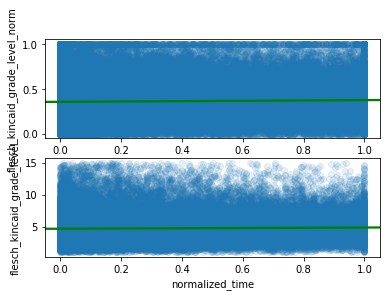

In [161]:
with HiddenPrints():
    plt.subplot(211)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level_norm',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    
    plt.subplot(212)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})

###### Plotting with Seaborn

*Seaborn makes fairly-pretty plots very easily, which is why I'm using it. Just pass in the relevant columns as x and y axes, and adjust the color as necessary, and there's a plot.*

Looks useless, huh? It's just all of the data together, but it has one important thing of note: the regression line is flat. Completely flat. That green line across the middle is what the trend throughout is, which means the trend across all of these authors is no-change.

Let's calculate it out exactly.

In [134]:
X = np.reshape(chapters.normalized_time.values, (-1,1))
y = chapters['flesch_kincaid_grade_level_norm']
regr = linear_model.LinearRegression()
regr.fit(X, y)
print("flesch_kincaid_grade_level_norm regression slope:", regr.coef_)

y = chapters['flesch_kincaid_grade_level']
regr = linear_model.LinearRegression()
regr.fit(X, y)
print("flesch_kincaid_grade_level regression slope:", regr.coef_)

flesch_kincaid_grade_level_norm regression slope: [0.01897461]
flesch_kincaid_grade_level regression slope: [0.1878507]


On average, the grade level an author writes at declines by about two-tenths of a point during the entirety of the time they're on fanfiction. That's an insignificant change.

After looking at that, I think it's time for some sanity-checks. I'm going to plot an array of values alongside each other to see if anything pops out visually.

Firstly, I'm going to divide the authors into 'buckets' based on how much data I have on them. Perhaps having the authors with 1000 chapters mixed in with the authors with 50 chapters is skewing my data towards a few individuals.

In [ ]:
authors = pd.read_sql_query('''SELECT * FROM authors WHERE author_id IN (SELECT author_id FROM chapters 
                                WHERE flesch_kincaid_grade_level < 15 AND flesch_kincaid_grade_level > 1 
                                AND words > sentences * 3 AND words < sentences * 50 AND words > 20 AND author_id 
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926))''', conn)

chapters = chapters.merge(authors, left_on='author_id', right_on='author_id') \
                       [['story_id' , 'chap_num' , 'words' , 'sentences' , 'syllables' , 'polysyl_words' ,
                         'difficult_words' , 'words_4_5' , 'words_6_9' , 'words_10_12' , 'words_longer_13' ,
                         'flesch_reading_ease' , 'flesch_kincaid_grade_level' , 'coleman_liau_index' ,
                         'gunning_fog_index' , 'smog_index' , 'ari_index' , 'lix_index' , 'dale_chall_score' , 
                         'lexical_diversity' , 'fkfjp_score' , 'overall_sequence' , 'estimated_time' ,
                         'normalized_time' , 'author_id', 'flesch_reading_ease_norm' , 
                         'flesch_kincaid_grade_level_norm' , 'coleman_liau_index_norm' ,
                         'gunning_fog_index_norm' , 'smog_index_norm' , 'ari_index_norm' , 'lix_index_norm' ,
                         'dale_chall_score_norm' , 'lexical_diversity_norm' , 'fkfjp_score_norm',
                         'checked_chapters']]

###### Merge is wonderful

*That line looks like a mess, but I just copy-pasted the fields from where I created the chapters table, then added checked-chapters and merged based on the author_id. I would have done this in SQL if SQLite supported merge.*

Now that I have the checked-chapters in the chapters table, it's easy to bin by that.

In [155]:
chapters['bin'] = pd.cut(chapters['checked_chapters'], 9, labels=[1,2,3,4,5,6,7,8,9])
by_bins = chapters.groupby('bin')

*The first command split the checked_chapters column into 9 even-sized bins and made the results into a new column on the dataframe. The second line made a group_by element on that so they're easy to sort by.*

Now, let's see some more general charts to suss out any patterns.

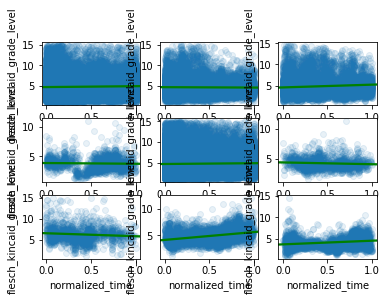

In [162]:
with HiddenPrints():
    plt.subplot(331)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(1), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(332)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(2), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(333)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(3), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(334)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(4), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(335) # turns out bin #5 is empty, but I didn't want to mess up my grid
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(336)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(6), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(337)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(7), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(338)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(8), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(339)
    sns.regplot(x='normalized_time', y='flesch_kincaid_grade_level',
                data = by_bins.get_group(9), scatter_kws={'alpha':0.1}, line_kws={'color':'green'})

In [167]:
for i, table in by_bins:
    if(len(table) != 0):
        print("Bin #", i, "has", len(table), "chapters in it")
        X = np.reshape(table.normalized_time.values, (-1,1))
        y = table['flesch_kincaid_grade_level_norm']
        regr = linear_model.LinearRegression()
        regr.fit(X, y)
        print("grade_level_norm regression slope:", regr.coef_)

        y = table['flesch_kincaid_grade_level']
        regr = linear_model.LinearRegression()
        regr.fit(X, y)
        print("grade_level regression slope:", regr.coef_)
        print('')

Bin # 1 has 56705 chapters in it
grade_level_norm regression slope: [0.03220576]
grade_level regression slope: [0.21568365]

Bin # 2 has 14632 chapters in it
grade_level_norm regression slope: [-0.00988751]
grade_level regression slope: [-0.09635463]

Bin # 3 has 9030 chapters in it
grade_level_norm regression slope: [0.05426665]
grade_level regression slope: [0.65389853]

Bin # 4 has 1559 chapters in it
grade_level_norm regression slope: [0.1182304]
grade_level regression slope: [-0.12508933]

Bin # 6 has 1357 chapters in it
grade_level_norm regression slope: [-0.03071028]
grade_level regression slope: [-0.29568487]

Bin # 7 has 1400 chapters in it
grade_level_norm regression slope: [-0.05141611]
grade_level regression slope: [-0.7121046]

Bin # 8 has 5015 chapters in it
grade_level_norm regression slope: [0.1006463]
grade_level regression slope: [1.46524835]

Bin # 9 has 3952 chapters in it
grade_level_norm regression slope: [-0.07120697]
grade_level regression slope: [0.84671268]



Even the most heavily-sloped bin, #1, only has a shift of 0.2 grade-levels across the entire time someone's on fanfiction.net. This confirms, to me, that there is no simple relationship between how long an author is writing fanfiction and how their writing complexity shifts.

I'm going to do another visual check, here. Earlier, I mentioned that I considered having all the metrics useful because it could be a check against errors. Doing the same chart with a mess of measures will help spot any anomalies.

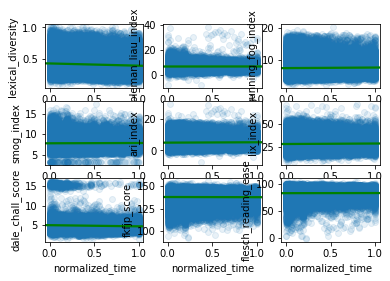

In [168]:
with HiddenPrints():
    plt.subplot(331)
    sns.regplot(x='normalized_time', y='lexical_diversity',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(332)
    sns.regplot(x='normalized_time', y='coleman_liau_index',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(333)
    sns.regplot(x='normalized_time', y='gunning_fog_index',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(334)
    sns.regplot(x='normalized_time', y='smog_index',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(335)
    sns.regplot(x='normalized_time', y='ari_index',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(336)
    sns.regplot(x='normalized_time', y='lix_index',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(337)
    sns.regplot(x='normalized_time', y='dale_chall_score',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(338)
    sns.regplot(x='normalized_time', y='fkfjp_score',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})
    plt.subplot(339)
    sns.regplot(x='normalized_time', y='flesch_reading_ease',
                data = chapters, scatter_kws={'alpha':0.1}, line_kws={'color':'green'})

To me, this confirms the lack of a simple relationship, so I'm moving on. (Also, the dale-chall score has too many outliers. I looked it up, and it relies on a word-list, which I think makes it less adaptable to niche genre fiction which has lots of custom words.)

#### The next question is, although they don't shift in a consistent direction, do they consistently shift?

This is where it's important to have read a bit about readability metrics. Higher isn't better, lower isn't better, middling isn't better. They don't measure 'better'. Every writer could be improving by shifting in a different direction. I'm going to calculate out the regression coefficient for each author individually and see if they tend to be high or not.

In [171]:
for author, table in by_author:
    for label in ['flesch_reading_ease', 'flesch_kincaid_grade_level', 'coleman_liau_index',
                  'gunning_fog_index', 'smog_index', 'ari_index', 'lix_index', 'lexical_diversity', 'fkfjp_score']:
        X = np.reshape(table.normalized_time.values, (-1,1))
        y = table[label]
        regr = linear_model.LinearRegression()
        regr.fit(X, y)
        authors.loc[authors['author_id'] == author, str(label) + '_coef'] = regr.coef_
        authors.loc[authors['author_id'] == author, str(label) + '_abs_coef'] = abs(regr.coef_)
        X = np.reshape(table.estimated_time.values, (-1,1))
        regr = linear_model.LinearRegression()
        regr.fit(X, y)
        authors.loc[authors['author_id'] == author, str(label) + '_est_coef'] = regr.coef_
        authors.loc[authors['author_id'] == author, str(label) + '_est_abs_coef'] = abs(regr.coef_)

I'm also adding an estimated-time coefficient, just to look. I can't do that one for mixed groups of authors, since they might have just been operating during different years, but when keeping it to a single author, I can see if things change without the normalization.

Now, I'm going to look at the averages from those things.

In [293]:
print("Grade-Level Mean, Normalized Time =", authors.flesch_kincaid_grade_level_coef.mean())
print("Grade-Level Mean, Real Time =", authors.flesch_kincaid_grade_level_est_coef.mean())
print("Grade-Level Absolute-Mean, Normalized Time =", authors.flesch_kincaid_grade_level_abs_coef.mean())
print("Grade-Level Absolute-Mean, Real Time =", authors.flesch_kincaid_grade_level_est_abs_coef.mean())

Grade-Level Mean, Normalized Time = 0.14791197948633197
Grade-Level Mean, Real Time = 1.7429375393246283e-09
Grade-Level Absolute-Mean, Normalized Time = 1.3366786482901567
Grade-Level Absolute-Mean, Real Time = 1.5277058931509717e-08


Now we're seeing a little change. I'm going to make a count-plot to display where authors cluster on this metric. To do that, I need them put in bins, but I can't just use a set number of bins from pandas.cut() because I want the resulting graph to center around 0. I'm first going to use that command to get the bins themselves, then I'm going to make my own bins based off of those ranges.

In [255]:
print(pd.cut(authors['flesch_kincaid_grade_level_coef'].values, 15).categories.format())
print(pd.cut(authors['lexical_diversity_coef'].values, 15).categories.format())

['(-10.738, -9.377]', '(-9.377, -8.036]', '(-8.036, -6.695]', '(-6.695, -5.354]', '(-5.354, -4.013]', '(-4.013, -2.672]', '(-2.672, -1.331]', '(-1.331, 0.0102]', '(0.0102, 1.351]', '(1.351, 2.692]', '(2.692, 4.033]', '(4.033, 5.374]', '(5.374, 6.715]', '(6.715, 8.056]', '(8.056, 9.397]']
['(-0.484, -0.411]', '(-0.411, -0.338]', '(-0.338, -0.266]', '(-0.266, -0.194]', '(-0.194, -0.121]', '(-0.121, -0.049]', '(-0.049, 0.0233]', '(0.0233, 0.0957]', '(0.0957, 0.168]', '(0.168, 0.24]', '(0.24, 0.313]', '(0.313, 0.385]', '(0.385, 0.457]', '(0.457, 0.53]', '(0.53, 0.602]']


In [289]:
bins = pd.IntervalIndex.from_tuples([(-11, -9), (-9, -7), (-7, -5), (-5, -3), (-3, -1), 
                                     (-1, 1), (1, 3), (3, 5), (5, 7), (7, 9), (9, 11)])
authors['binned_gl_slope'] = pd.cut(authors['flesch_kincaid_grade_level_coef'], bins)
sns.set(rc={'figure.figsize':(10,6)})

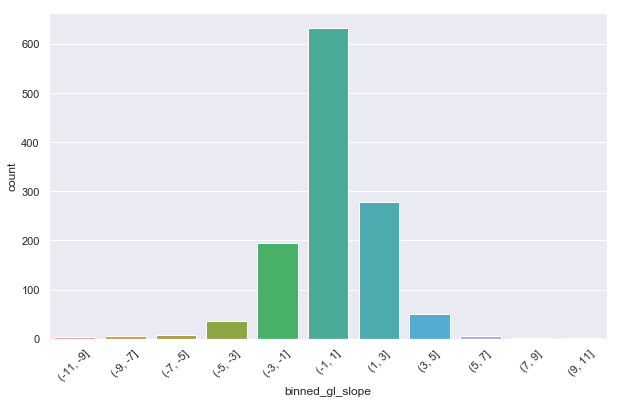

In [290]:
with HiddenPrints():
    plot = sns.countplot(x="binned_gl_slope", data=authors)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

Centered around 0, this is a very narrow bell-curve, agreeing with earlier inferences that there is no clear direction to the change. That said, there is actually a lot of change. 

In [291]:
bins = pd.IntervalIndex.from_tuples([(0, 0.4), (0.4, 0.8), (0.8, 1.2), (1.2, 2), (2, 2.5), (2.5, 3), (5, 11)])
authors['binned_gl_slope_distorted'] = pd.cut(authors['flesch_kincaid_grade_level_abs_coef'], bins)
authors.groupby('binned_gl_slope_distorted').agg({'binned_gl_slope_distorted' : ['count']})

,binned_gl_slope_distorted
,count
binned_gl_slope_distorted,
"(0.0, 0.4]",282
"(0.4, 0.8]",245
"(0.8, 1.2]",184
"(1.2, 2.0]",251
"(2.0, 2.5]",81
"(2.5, 3.0]",61
"(5.0, 11.0]",23


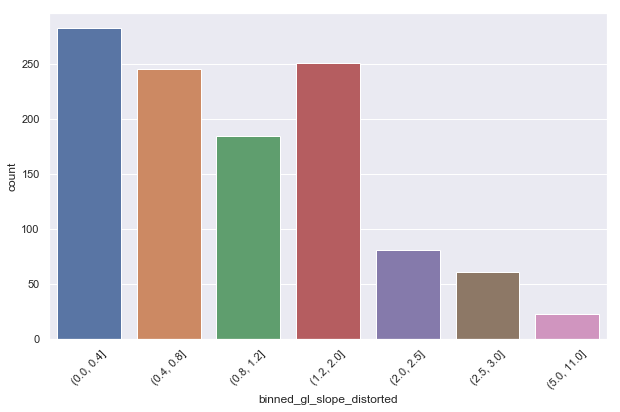

In [292]:
with HiddenPrints():
    plot = sns.countplot(x="binned_gl_slope_distorted", data=authors)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

Yes, that's an intentionally distorted graph. I'm doing that because the wide range of changes has outliers making the center of the graph look tiny. It's not tiny. An average change of less than 0.4 is small, but that's just 282 out of 1214 (23%). These are grade-level changes, and those happen in a relatively-narrow band.

# Conclusions

Going back to the initial article on reading levels I linked (https://contently.com/2015/01/28/this-surprising-reading-level-analysis-will-change-the-way-you-write/), it's clear how narrow of a band most reading levels are in. An increase of 'only' 1.5 grade-levels is about the same as the shift between the first and last Harry-Potter books, and that represents more of a shift than most professional authors undergo in their writing. A total of 435 (36%) of all the authors I looked at had a change similar to that magnitude.

So, fanfiction.net authors are shifting in the complexity of their writing as they continue, it's just that the direction of the change is basically random.

## Also, making that database

If you're using the partial database I uploaded, it was made with the following commands:

In [342]:
conn = sqlite3.connect('fanfics.db')

chapters = pd.read_sql_query('''SELECT story_id ,chap_num , words , sentences , syllables , polysyl_words ,
                                difficult_words , words_4_5 , words_6_9 , words_10_12 , words_longer_13 ,
                                flesch_reading_ease , flesch_kincaid_grade_level , coleman_liau_index ,
                                gunning_fog_index , smog_index , ari_index , lix_index , dale_chall_score , 
                                lexical_diversity , fkfjp_score FROM chapters WHERE 
                                estimated_time IS NOT NULL AND flesch_kincaid_grade_level_norm IS NOT NULL
                                AND story_id IN (SELECT story_id FROM stories WHERE author_id
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926))''', conn)

stories = pd.read_sql_query('''SELECT * FROM stories WHERE story_id IN
                               (SELECT story_id FROM chapters WHERE flesch_kincaid_grade_level < 15 AND
                                flesch_kincaid_grade_level > 1 AND words > sentences * 3 AND
                                words < sentences * 50 AND words > 20 AND author_id 
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926))''', conn)

authors = pd.read_sql_query('''SELECT author_id, checked_chapters  FROM authors WHERE author_id IN
                               (SELECT author_id FROM chapters WHERE flesch_kincaid_grade_level < 15 AND
                                flesch_kincaid_grade_level > 1 AND words > sentences * 3 AND
                                words < sentences * 50 AND words > 20 AND author_id 
                                IN (SELECT author_id FROM authors WHERE checked_chapters > 10
                                AND author_id <> 0 AND (last_time - first_time) > 31556926))''', conn)

conn = sqlite3.connect('shrunken.db')

chapters.to_sql('chapters', con=conn, if_exists='replace')
stories.to_sql('stories', con=conn, if_exists='replace')
authors.to_sql('authors', con=conn, if_exists='replace')